In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

# Задание 1

In [51]:
all_data = pd.read_csv('owid-covid-data.csv')

In [3]:
all_data['date'] = all_data['date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))

In [4]:
d = datetime.timedelta(days = 50)
data = all_data[(all_data['location'] == 'Russia')\
                & (all_data['date'] >= pd.to_datetime('2020-3-3'))\
                & (all_data['date'] < pd.to_datetime('2020-3-3') + d)]
train_data = data.reset_index()
d = {i:num for num,i in enumerate(train_data.date.to_list())}
train_data['num_day'] = train_data['date'].map(d)

# Задание 2

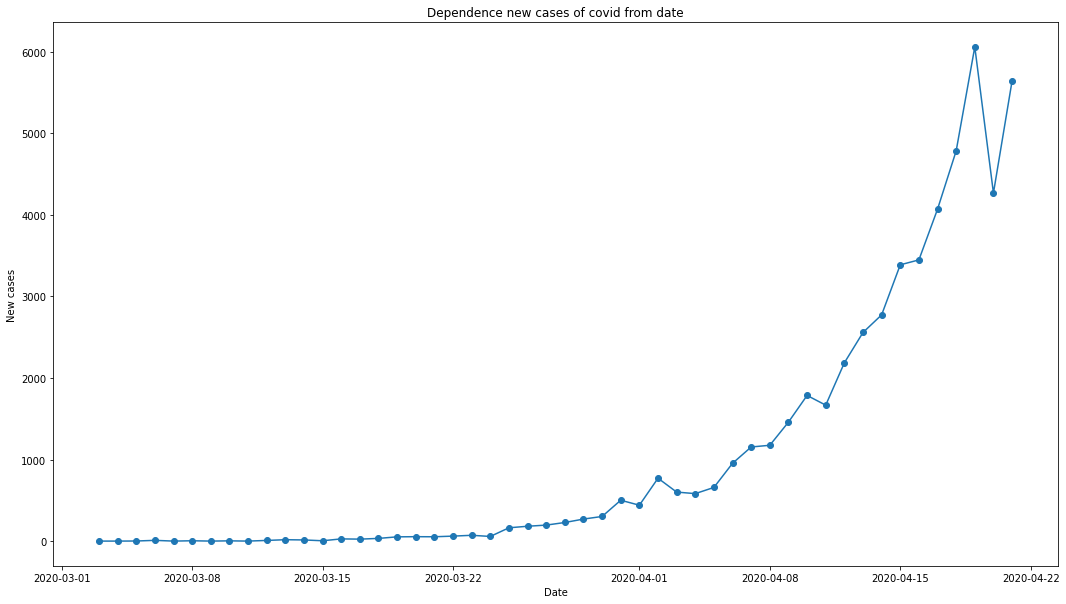

In [5]:
plt.figure(figsize=(18,10))
plt.xlabel('Date')
plt.ylabel('New cases')
plt.title('Dependence new cases of covid from date')
plt.plot(train_data['date'], train_data['new_cases'], marker = 'o')
plt.show()

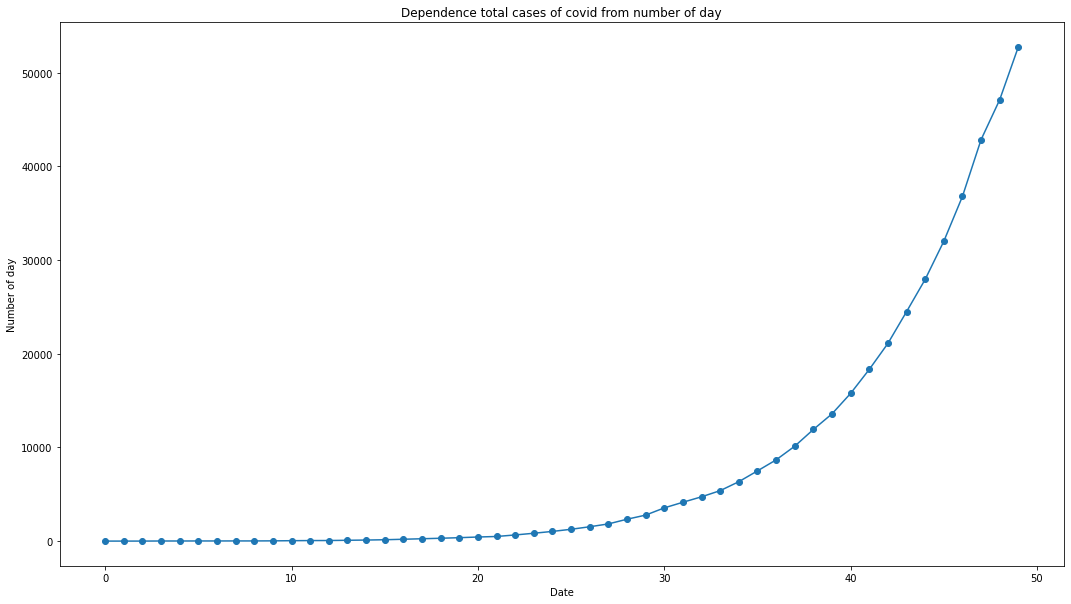

In [6]:
plt.figure(figsize=(18,10))
plt.xlabel('Date')
plt.ylabel('Number of day')
plt.title('Dependence total cases of covid from number of day')
plt.plot(train_data['num_day'], train_data['total_cases'], marker = 'o')
plt.show()

Из этих графиков видно, что целевые переменные Total cases и New cases в целом похожи и коррелируют, а значит в дальнейшем сосредоточимся только на total cases, так как со второй целевой переменной можно будет провести аналогичные манипулиции и результат будет тот же.

### Пункт 2.а

In [7]:
X_train = np.array(train_data['num_day']).reshape((-1, 1))
y_train = np.log(np.array(train_data['total_cases']).reshape((-1, 1)))

In [8]:
first_model_of_tot_cases = linear_model.Ridge(fit_intercept=True, alpha = 0.01).fit(X_train,y_train)
print(first_model_of_tot_cases.coef_, first_model_of_tot_cases.intercept_)

[[0.19829072]] [1.82074181]


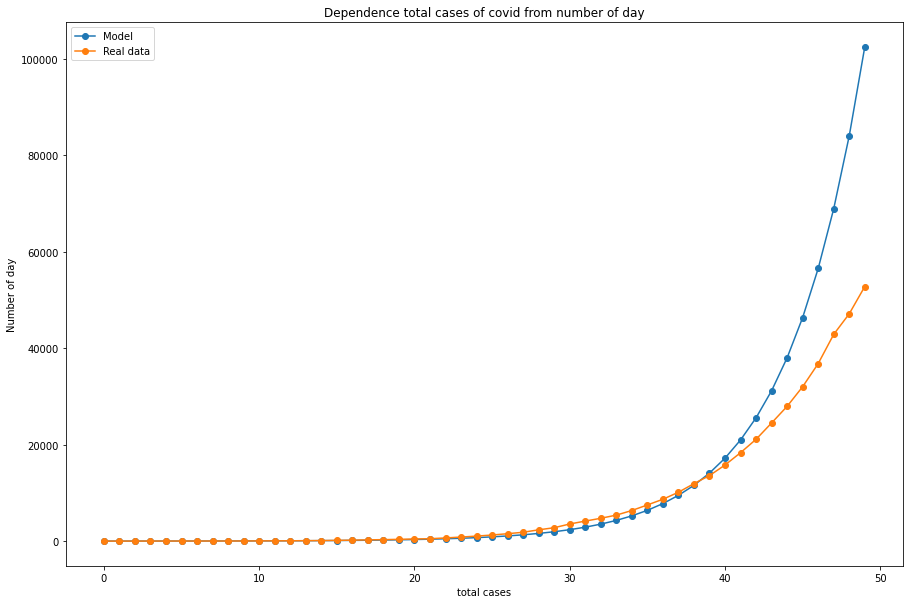

In [9]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.plot(train_data['num_day'], np.exp(first_model_of_tot_cases.predict(X_train)), marker = 'o', label = 'Model')
ax.plot(train_data['num_day'], train_data['total_cases'], marker = 'o', label = 'Real data')
ax.set_xlabel('total cases')
ax.set_ylabel('Number of day')
ax.set_title('Dependence total cases of covid from number of day')
ax.legend()
plt.show()

### Пункт 2.b

Оценим апостериорное распределение

Апостериорное распределение:
$p(\vec w|D) {\propto} p(\vec w)p(D|\vec w) = N(\vec w|0, \alpha I)*\prod_{n} N(y_n|\vec{w^T}\vec{x_n},\sigma^2) = N(\vec w| \bar{\mu_{N}}, \Sigma_{N})$

$\Sigma_{N}^{-1} = \alpha I^{-1}+\frac{X^{T}X}{\sigma ^2}$

$\bar\mu_{N} = \Sigma_{N}\frac{X^T\vec y}{\sigma^2}$

Коэффициент регуляризации: $\lambda = \frac{\sigma^2}{\alpha}=0.01$

Выбрал $\lambda$ меньше, чтобы расширить априорное распределение

 Определим стандартное $\sigma$

In [10]:
#оценка дисперсии шума в данных
sigma = np.std(y_train - first_model_of_tot_cases.predict(X_train))
alpha = sigma**2 / 0.01
alpha

12.183046155146462

In [11]:
temp_X_extended = np.concatenate((np.ones(X_train.shape), X_train), axis=1)
matr_cov = alpha * np.eye(2)

In [12]:
inv_matr_cov = np.linalg.inv(matr_cov)
mat_mul_of_X = temp_X_extended.T.dot(temp_X_extended) / (sigma**2)
#параметры апостериорного распределения
Sigma = np.linalg.inv(inv_matr_cov + mat_mul_of_X)
mu = Sigma @ temp_X_extended.T.dot(y_train)/(sigma**2)

In [13]:
#сэмплируем веса из распределения
array_of_weights = np.random.multivariate_normal(mu.reshape(-1), Sigma, 1000)

In [14]:
arr_of_posterior_exp = list()
for idx, i in enumerate(array_of_weights):
    arr_of_posterior_exp.append(np.exp(np.sum(i * temp_X_extended, axis=1)))
arr_of_posterior_exp = np.array(arr_of_posterior_exp)
print(arr_of_posterior_exp.shape)

(1000, 50)


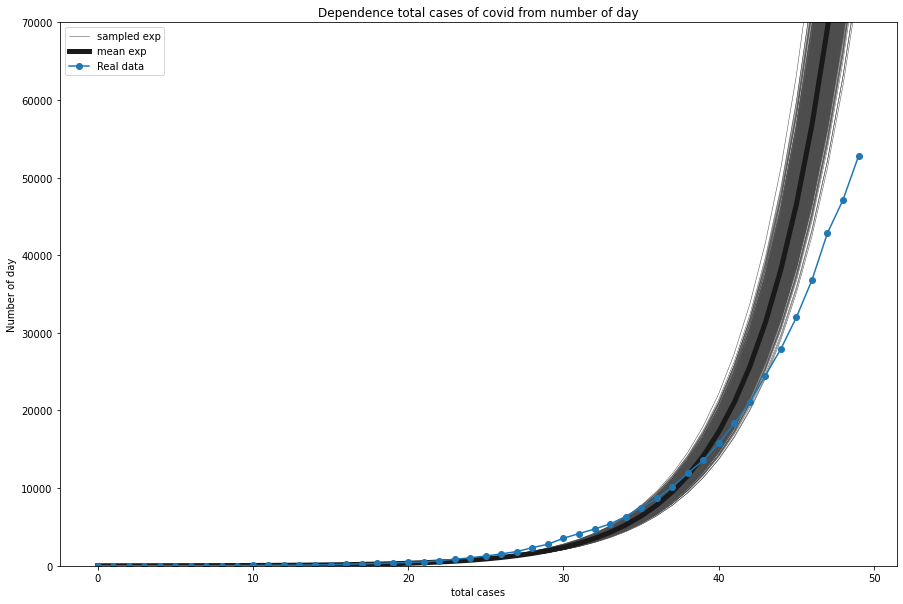

In [15]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.set_ylim((0,70000))
for i in range(arr_of_posterior_exp.shape[0]):
    if i == 0:
        ax.plot(train_data['num_day'], arr_of_posterior_exp[i], linewidth=.5, color="0.3", label = 'sampled exp')
    else:
        ax.plot(train_data['num_day'], arr_of_posterior_exp[i], linewidth= .5, color="0.3")
ax.plot(train_data['num_day'], arr_of_posterior_exp.mean(axis = 0), linewidth=5, color="0.1", label = 'mean exp')
ax.plot(train_data['num_day'], train_data['total_cases'], marker = 'o', label = 'Real data')
ax.set_xlabel('total cases')
ax.set_ylabel('Number of day')
ax.set_title('Dependence total cases of covid from number of day')
ax.legend()
plt.show()

### Пункт 2.с

In [16]:
d = datetime.timedelta(days = 183) #60, 91, 183
data = all_data[(all_data['location'] == 'Russia')\
                & (all_data['date'] >= pd.to_datetime('2020-3-3'))\
                & (all_data['date'] < pd.to_datetime('2020-3-3') + d)]
test_data = data.reset_index()
d = {i:num for num,i in enumerate(test_data.date.to_list())}
test_data['num_day'] = test_data['date'].map(d)

In [17]:
test_data

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,num_day
0,121390,RUS,Europe,Russia,2020-03-03,3.0,0.0,0.143,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,0
1,121391,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,1
2,121392,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,2
3,121393,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,3
4,121394,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,121568,RUS,Europe,Russia,2020-08-28,977730.0,4758.0,4722.714,16866.0,108.0,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,178
179,121569,RUS,Europe,Russia,2020-08-29,982573.0,4843.0,4720.286,16977.0,111.0,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,179
180,121570,RUS,Europe,Russia,2020-08-30,987470.0,4897.0,4734.571,17045.0,68.0,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,180
181,121571,RUS,Europe,Russia,2020-08-31,992402.0,4932.0,4769.429,17128.0,83.0,...,58.3,NaN,8.05,72.58,0.824,103778.1,8.71,14.54,711.237488,181


In [18]:
temp_X_test = np.array([[1,i] for i in range(1, test_data.shape[0]+1)])

In [19]:
arr_of_posterior_exp_test = list()
for idx, i in enumerate(array_of_weights):
    arr_of_posterior_exp_test.append(np.exp(np.sum(i * temp_X_test, axis=1)))
arr_of_posterior_exp_test = np.array(arr_of_posterior_exp_test)
print(arr_of_posterior_exp_test.shape)

(1000, 183)


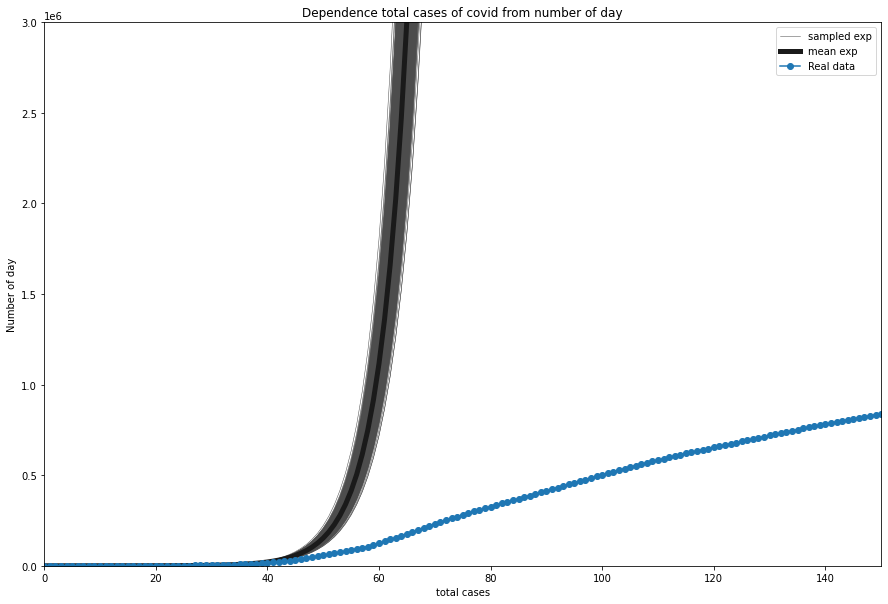

In [20]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.set_ylim((0,3e6))
ax.set_xlim((0,150))

for i in range(arr_of_posterior_exp.shape[0]):
    if i == 0:
        ax.plot(test_data['num_day'], arr_of_posterior_exp_test[i], linewidth=.5, color="0.3", label = 'sampled exp')
    else:
        ax.plot(test_data['num_day'], arr_of_posterior_exp_test[i], linewidth= .5, color="0.3")
ax.plot(test_data['num_day'], arr_of_posterior_exp_test.mean(axis = 0), linewidth=5, color="0.1", label = 'mean exp')
ax.plot(test_data['num_day'], test_data['total_cases'], marker = 'o', label = 'Real data')
ax.set_xlabel('total cases')
ax.set_ylabel('Number of day')
ax.set_title('Dependence total cases of covid from number of day')
ax.legend()
plt.show()

In [21]:
arr_of_posterior_exp_test.mean(axis = 0)[-1]

4.143720116443099e+16

Наше предсказание превышает итоговый таргет на 10 порядков. Получается по данной модели к первому сентября ковид начнет заражать внеземные цивилизации))

# Задание 3

Чтобы обучить функцию $\Phi(x) = \frac{1}{\sqrt {2\pi}} \int_{-\infty}^{x} e^{\frac{-t^2}{2}}dt$

Возьмем функцию: $y = \int_{-\infty}^{x}e^{w_0+w_1x+w_{2}x^2}$

Тогда: $y' = e^{w^Tx}$

$ln(y') = w^Tx$, где $y'_0 = \frac{-3y_0+4y_1-y_2}{2h}$, $y_n = \frac{y_n+1-y_n-1}{2h}$, $y_N = \frac{y_{N-2}-4y_{N-1}+3y_{N}}{2h}$

# Пункт 3.а

In [22]:
h = train_data['num_day'].iloc[1] - train_data['num_day'].iloc[0]

In [23]:
deriative_of_y = list()
arr_of_tot_cases = np.array(train_data['total_cases'].to_list())
deriative_of_y.append((-3*arr_of_tot_cases[0] + 4 * arr_of_tot_cases[1] - arr_of_tot_cases[2])/(2*h))
for i in range(1, len(arr_of_tot_cases)-1):
    deriative_of_y.append((arr_of_tot_cases[i+1]-arr_of_tot_cases[i-1])/(2*h))
deriative_of_y.append((arr_of_tot_cases[-3] - 4 * arr_of_tot_cases[-2] + 3 * arr_of_tot_cases[-1])/(2*h))
deriative_of_y = np.array(deriative_of_y)

In [24]:
deriative_of_y[deriative_of_y < 1] = 1

In [25]:
train_y_Gauss = np.log(deriative_of_y)

Посмотрим насколько линейным получился таргет

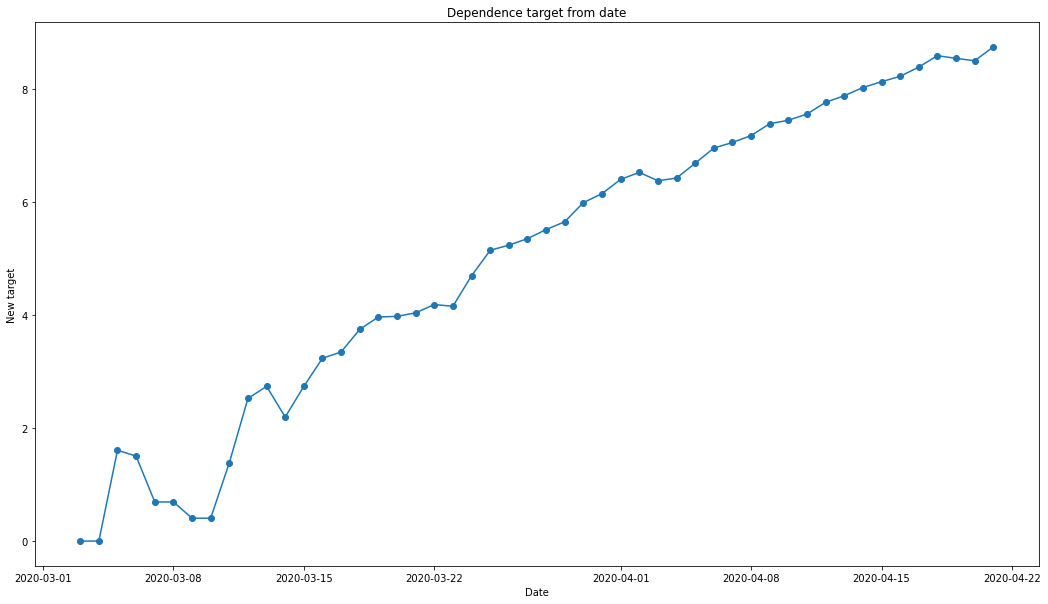

In [26]:
plt.figure(figsize=(18,10))
plt.xlabel('Date')
plt.ylabel('New target')
plt.title('Dependence target from date')
plt.plot(train_data['date'], train_y_Gauss, marker = 'o')
plt.show()

График получился линейный значит можно обучать

In [27]:
train_x_Gauss = np.concatenate((np.array([1 for i in range(train_data.shape[0])]).reshape(-1,1)\
                , np.array(train_data['num_day'].to_list()).reshape(-1,1)\
                , np.array(train_data['num_day'].to_list()).reshape(-1,1)**2), axis = 1)

In [28]:
Gauss_model_of_tot_cases = linear_model.Ridge(fit_intercept=False, alpha = 0.01).fit(train_x_Gauss, train_y_Gauss)
print(Gauss_model_of_tot_cases.coef_)

[-0.14616722  0.26869706 -0.00177047]


##### Посмотрим, что получилось после обучения на трейне

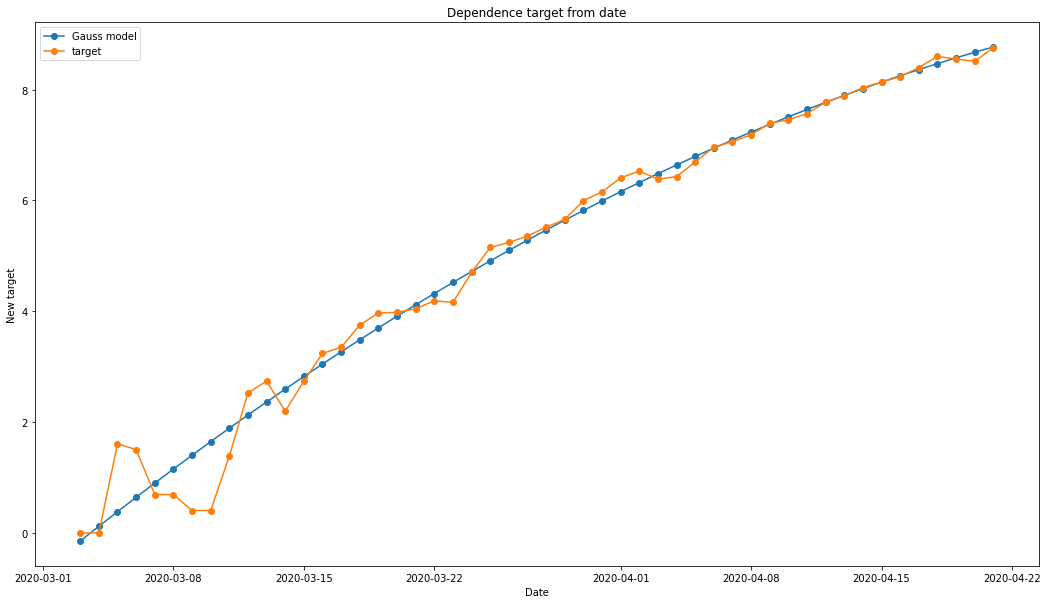

In [29]:
plt.figure(figsize=(18,10))
plt.xlabel('Date')
plt.ylabel('New target')
plt.title('Dependence target from date')
plt.plot(train_data['date'], Gauss_model_of_tot_cases.predict(train_x_Gauss), marker = 'o', label = 'Gauss model')
plt.plot(train_data['date'], train_y_Gauss, marker = 'o', label = 'target')
plt.legend()
plt.show()

In [30]:
predict_x_Gauss_deriative = np.exp(Gauss_model_of_tot_cases.predict(train_x_Gauss))

Чтобы вернуться от $y'$ к y, $y_{i+1} = y_i + y'_ih$

В качестве $y_{-1} = 1$

Тут можно было сделать иначе, но было интересно насколько сильно просядет точность при таком переходе от массива производных к массиву значений функции

In [31]:
predict_x_Gauss = list()
predict_x_Gauss.append(1 + predict_x_Gauss_deriative[0]*h)
for i in range(1, len(predict_x_Gauss_deriative)):
    predict_x_Gauss.append(predict_x_Gauss[i-1] + predict_x_Gauss_deriative[i]*h)

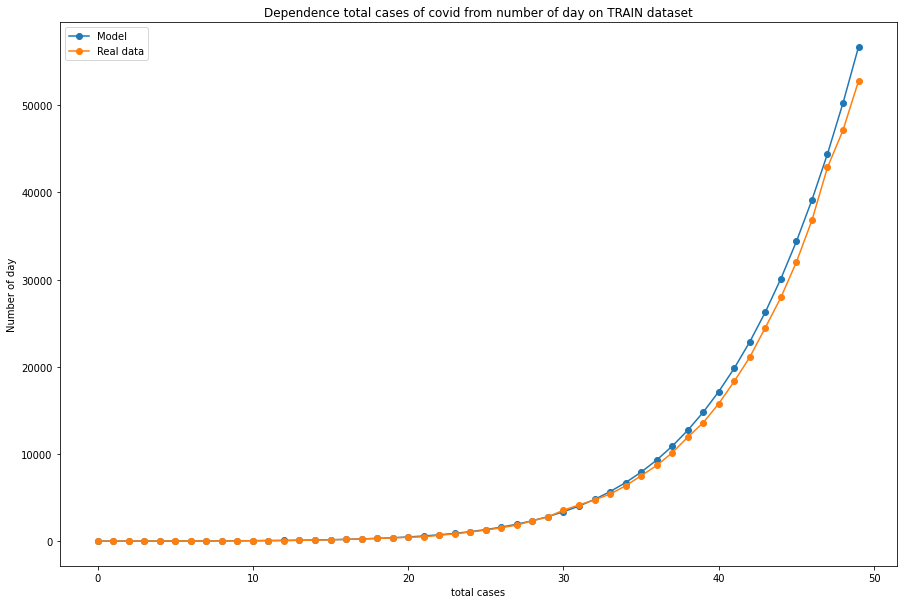

In [32]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.plot(train_data['num_day'], predict_x_Gauss, marker = 'o', label = 'Model')
ax.plot(train_data['num_day'], train_data['total_cases'], marker = 'o', label = 'Real data')
ax.set_xlabel('total cases')
ax.set_ylabel('Number of day')
ax.set_title('Dependence total cases of covid from number of day on TRAIN dataset')
ax.legend()
plt.show()

##### Теперь на тесте

In [33]:
test_x_Gauss = np.concatenate((np.array([1 for i in range(test_data.shape[0])]).reshape(-1,1)\
                , np.array(test_data['num_day'].to_list()).reshape(-1,1)\
                , np.array(test_data['num_day'].to_list()).reshape(-1,1)**2), axis = 1)

In [34]:
predict_x_test_Gauss_deriative = np.exp(Gauss_model_of_tot_cases.predict(test_x_Gauss))

In [35]:
predict_x_test_Gauss = list()
predict_x_test_Gauss.append(1 + predict_x_test_Gauss_deriative[0]*h)
for i in range(1, len(predict_x_test_Gauss_deriative)):
    predict_x_test_Gauss.append(predict_x_test_Gauss[i-1] + predict_x_test_Gauss_deriative[i]*h)

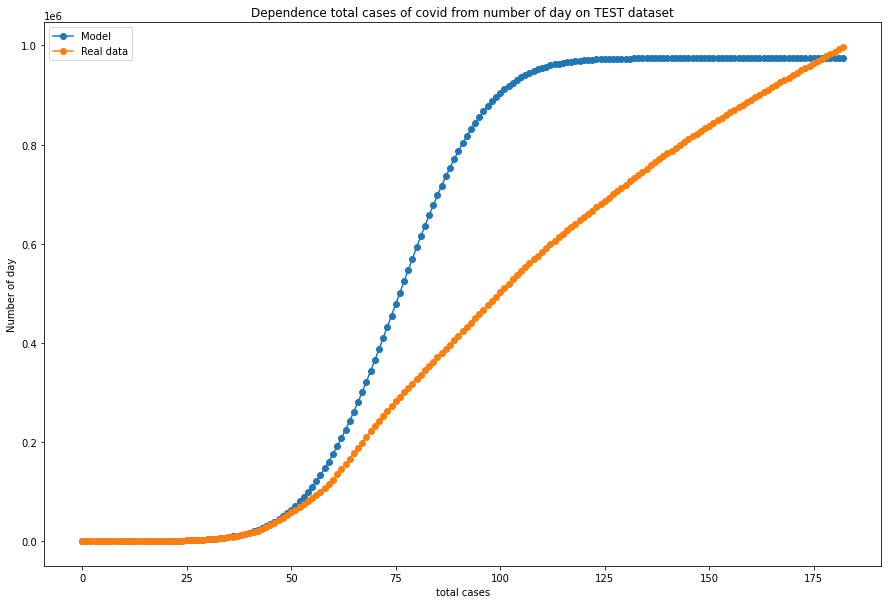

In [36]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.plot(test_data['num_day'], predict_x_test_Gauss, marker = 'o', label = 'Model')
ax.plot(test_data['num_day'], test_data['total_cases'], marker = 'o', label = 'Real data')
ax.set_xlabel('total cases')
ax.set_ylabel('Number of day')
ax.set_title('Dependence total cases of covid from number of day on TEST dataset')
ax.legend()
plt.show()

Ну по итогу обучили сигмоиду, как просили в задании, однако реальные данные отличаются от сигмоиды. И данная модель не подходит для данной задачи.

# Пункт 3.b

Теперь найдем апостериорное распределение параметров и покажем результаты на тестовой выборке

In [37]:
sigma_Gauss = np.std(np.array(train_data['total_cases'])-predict_x_Gauss)

In [38]:
alpha2 = sigma_Gauss**2 / 0.01

In [39]:
inv_matr_cov = np.linalg.inv(alpha2 * np.eye(3))
mat_mul_of_X = train_x_Gauss.T.dot(train_x_Gauss) / (sigma**2)
#параметры апостериорного распределения
Sigma = np.linalg.inv(inv_matr_cov + mat_mul_of_X)
mu = Sigma @ train_x_Gauss.T.dot(train_y_Gauss)/(sigma**2)

In [40]:
array_of_weights_Gauss = np.random.multivariate_normal(mu.reshape(-1), Sigma, 1000)

In [41]:
array_of_scalar_product_gauss = list()
for idx, weights in enumerate(array_of_weights_Gauss):
    array_of_scalar_product_gauss.append(np.sum(weights * train_x_Gauss, axis = 1))
array_of_scalar_product_gauss = np.array(array_of_scalar_product_gauss)

In [42]:
exp_of_posterioir_gauss = np.exp(array_of_scalar_product_gauss)

In [43]:
def from_deriative_to_y(list_of_deriative, h, y0):
    arr_of_y = list()
    arr_of_y.append(y0 + list_of_deriative[0]*h)
    for i in range(1, len(list_of_deriative)):
        arr_of_y.append(arr_of_y[i-1] + list_of_deriative[i]*h)
    return np.array(arr_of_y)

In [44]:
posterior_predict = list()
for arr_of_deriative in exp_of_posterioir_gauss:
    posterior_predict.append(from_deriative_to_y(arr_of_deriative, h, 1))
posterior_predict= np.array(posterior_predict)

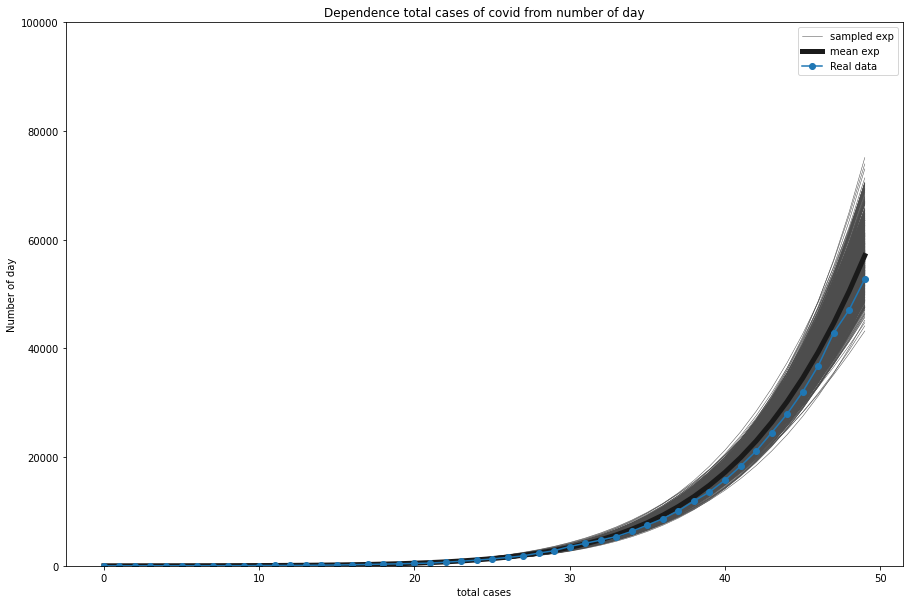

In [45]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.set_ylim((0,100000))
for i in range(posterior_predict.shape[0]):
    if i == 0:
        ax.plot(train_data['num_day'], posterior_predict[i], linewidth=.5, color="0.3", label = 'sampled exp')
    else:
        ax.plot(train_data['num_day'], posterior_predict[i], linewidth= .5, color="0.3")
ax.plot(train_data['num_day'], posterior_predict.mean(axis = 0), linewidth=5, color="0.1", label = 'mean exp')
ax.plot(train_data['num_day'], train_data['total_cases'], marker = 'o', label = 'Real data')
ax.set_xlabel('total cases')
ax.set_ylabel('Number of day')
ax.set_title('Dependence total cases of covid from number of day')
ax.legend()
plt.show()

# Пункт 3.c

Теперь построим данный график для тестовой части выборки

In [46]:
test_X_Gauss = np.array([[1,i, i*i] for i in range(1, test_data.shape[0]+1)])

In [47]:
array_of_scalar_product_gauss = list()
for idx, weights in enumerate(array_of_weights_Gauss):
    array_of_scalar_product_gauss.append(np.sum(weights * test_X_Gauss, axis = 1))
array_of_scalar_product_gauss = np.array(array_of_scalar_product_gauss)
exp_of_posterioir_gauss = np.exp(array_of_scalar_product_gauss)
print(exp_of_posterioir_gauss.shape)

(1000, 183)


In [48]:
posterior_predict = list()
for arr_of_deriative in exp_of_posterioir_gauss:
    posterior_predict.append(from_deriative_to_y(arr_of_deriative, h, 1))
posterior_predict= np.array(posterior_predict)

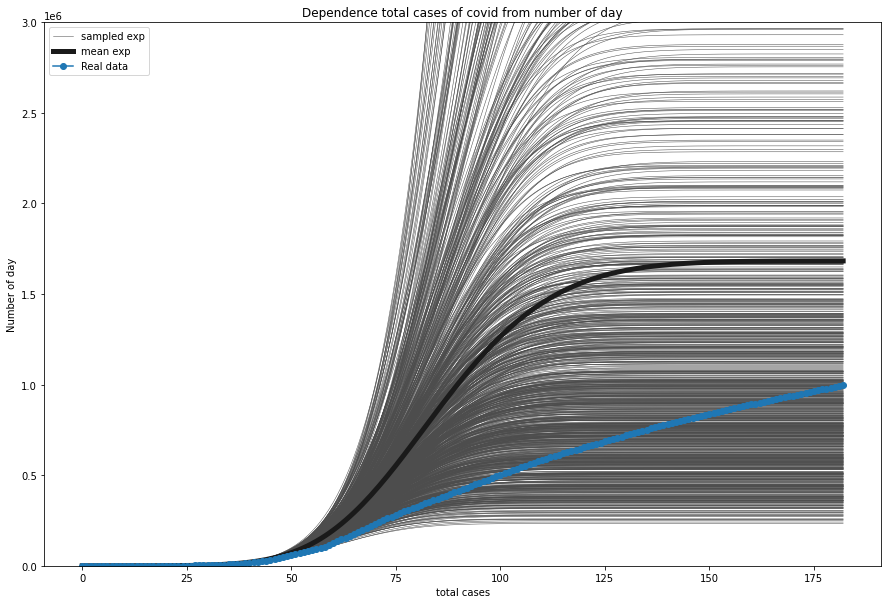

In [49]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.set_ylim((0,3e6))
for i in range(posterior_predict.shape[0]):
    if i == 0:
        ax.plot(test_data['num_day'], posterior_predict[i], linewidth=.5, color="0.3", label = 'sampled exp')
    else:
        ax.plot(test_data['num_day'], posterior_predict[i], linewidth= .5, color="0.3")
ax.plot(test_data['num_day'], posterior_predict.mean(axis = 0), linewidth=5, color="0.1", label = 'mean exp')
ax.plot(test_data['num_day'], test_data['total_cases'], marker = 'o', label = 'Real data')
ax.set_xlabel('total cases')
ax.set_ylabel('Number of day')
ax.set_title('Dependence total cases of covid from number of day')
ax.legend()
plt.show()

По итогу сигмоида не подходит, однако можно оценить верхнюю границу

In [50]:
np.percentile(posterior_predict[::,-1], [10,90]).round(0)

array([ 439743., 3146796.])

Получается, что в оптимистичном сценарии будет 440 000 заболеваний, а в пессимистичном 3 миллиона.

Данная модель по хорошему должна включать куда больше параметров, так как на развитие пандемии может влиять множество разных параметров. Чтобы наша модель показывала приближенно похожие цифры, а не просто оценку.

По итогу, говоря о принятии решений и мер по пандемии, в наших же интересах исходить из худшего случая. К проблемам,которые влекут гибель людей нельзя относиться беспечно и принимать во внимание самые страшные варианты развитие. (По-хорошему так должно быть всегда, исходим из худшего случая, надеемся на лучшее)